# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

In [3]:
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

In [4]:
import os
import sys
import argparse
import shutil

import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path

from scib_metrics.benchmark import Benchmarker

from drvi_notebooks.utils.data.adata_plot_pp import make_balanced_subsample
from drvi_notebooks.utils.data.data_configs import get_data_info
from drvi_notebooks.utils.run_info import get_run_info_for_dataset
from drvi_notebooks.utils.method_info import pretify_method_name
from drvi_notebooks.utils.latent import set_optimal_ordering

In [5]:
sc.set_figure_params(vector_friendly=True, dpi_save=300)

# Config

In [6]:
parser = argparse.ArgumentParser()

parser.add_argument('--run-name', type=str)

interactive = False
if hasattr(sys, 'ps1'):
    args = parser.parse_args("--run-name immune_hvg".split(" "))
    interactive = True
else:
    args = parser.parse_args()
print(args)

Namespace(run_name='immune_hvg')


In [7]:
cwd = os.getcwd()
cwd

'/ictstr01/home/icb/amirali.moinfar/projects/drvi_reproducibility_public/drvi_notebooks/evaluation'

In [8]:
proj_dir = Path(cwd).parent.parent
proj_dir

PosixPath('/ictstr01/home/icb/amirali.moinfar/projects/drvi_reproducibility_public')

In [9]:
logs_dir = Path(os.path.expanduser('~/workspace/train_logs'))
logs_dir

PosixPath('/home/icb/amirali.moinfar/workspace/train_logs')

In [10]:
run_name = args.run_name
real_run_name = run_name
if run_name == 'zebrafish_hvg_128':
    real_run_name = 'zebrafish_hvg'
if run_name.endswith("_ablation"):
    real_run_name = run_name[:-len("_ablation")]
if run_name in ['immune_all_hbw_ablation']:
    real_run_name = 'immune_all'
run_version = '4.3'
run_path = os.path.expanduser('~/workspace/train_logs/models')

data_info = get_data_info(real_run_name, run_version)
wandb_address = data_info['wandb_address']
col_mapping = data_info['col_mapping']
plot_columns = data_info['plot_columns']
pp_function = data_info['pp_function']
data_path = data_info['data_path']
var_gene_groups = data_info['var_gene_groups']
cell_type_key = data_info['cell_type_key']
exp_plot_pp = data_info['exp_plot_pp']
control_treatment_key = data_info['control_treatment_key']
condition_key = data_info['condition_key']
split_key = data_info['split_key']

In [11]:
import mplscience
mplscience.available_styles()
mplscience.set_style()

['default', 'despine']


In [12]:
cat_10_pallete = sc.plotting.palettes.vega_10_scanpy
cat_20_pallete = sc.plotting.palettes.vega_20_scanpy
wong_pallete = [
    "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000",
]
cat_100_pallete = sc.plotting.palettes.godsnot_102

In [13]:
methods_to_plot = ["DRVI", "DRVI-IK", "scVI", "TCVAE-opt", "MICHIGAN-opt", "PCA", "ICA", "MOFA"]

## Runs to load

In [14]:
run_info = get_run_info_for_dataset(run_name)
RUNS_TO_LOAD = run_info.run_dirs
scatter_point_size = run_info.scatter_point_size
adata_to_transfer_obs = run_info.adata_to_transfer_obs

for k,v in RUNS_TO_LOAD.items():
    if not os.path.exists(v):
        raise ValueError(f"{v} does not exists.")

In [15]:
embeds = {}
random_order = None
for method_name, run_path in RUNS_TO_LOAD.items():
    print(method_name)
    if str(run_path).endswith(".h5ad"):
        embed = sc.read(run_path)
    else:
        embed = sc.read(run_path / 'latent.h5ad')
    if embed.n_vars > 512:
        embed = embed[:, np.abs(embed.X).max(axis=0) > 0.1].copy()
    pp_function(embed)
    set_optimal_ordering(embed, key_added='optimal_var_order')    
    if random_order is None:
        random_order = embed.obs.sample(frac=1.).index
    embed = embed[random_order].copy()
    embeds[method_name] = embed

DRVI
DRVI-IK
scVI
PCA
ICA
MOFA
TCVAE-opt
MICHIGAN-opt
DRVI-CVAE


SCIB for DRVI already calculated.
SCIB for DRVI-IK already calculated.
SCIB for scVI already calculated.
SCIB for PCA already calculated.
SCIB for ICA already calculated.
SCIB for MOFA already calculated.
SCIB for TCVAE-opt already calculated.
SCIB for MICHIGAN-opt already calculated.
SCIB for DRVI-CVAE already calculated.


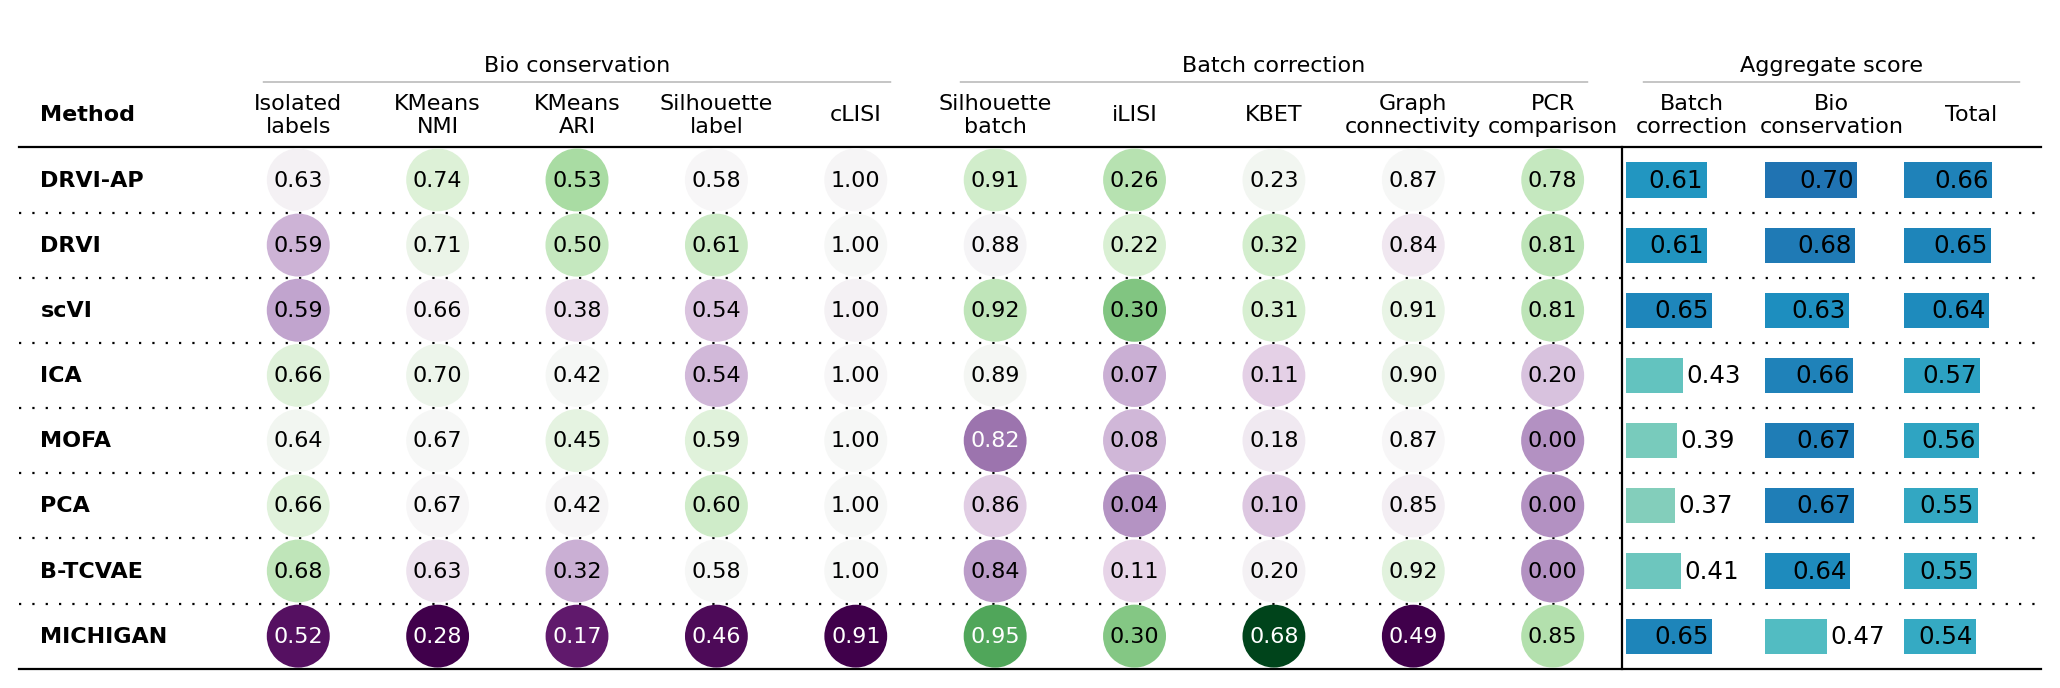

In [16]:
CHECK_SCIB_METRICS = True
FORCE_RERUN_SCIB = False

if condition_key is not None:
    adata = sc.read(data_path)
    if exp_plot_pp is not None:
        exp_plot_pp(adata, reduce=False)
    
    results = {}
    for method_name, run_path in RUNS_TO_LOAD.items():
        if str(run_path).endswith(".h5ad"):
            scib_metrics_save_path = str(run_path)[:-len(".h5ad")] + '_scib_metrics.csv'
        else:
            scib_metrics_save_path = run_path / 'scib_metrics.csv'
        if FORCE_RERUN_SCIB or not os.path.exists(scib_metrics_save_path):
            print(f"calculating SCIB for {method_name} ...")
            adata.obsm[method_name] = embeds[method_name][adata.obs.index].X
            bench = Benchmarker(adata, condition_key, cell_type_key, embedding_obsm_keys=[method_name])
            bench.benchmark()
            results[method_name] = bench._results
            bench._results.to_csv(scib_metrics_save_path)
        else:
            print(f"SCIB for {method_name} already calculated.")
            results[method_name] = pd.read_csv(scib_metrics_save_path, index_col=0)
            results[method_name].columns = [method_name] + list(results[method_name].columns[1:])

    results_prety = {}
    for method_name, result_df in results.items():
        if method_name not in methods_to_plot:
            continue
        assert result_df.columns[0] == method_name
        result_df.rename(columns={method_name: pretify_method_name(method_name)}, inplace=True)
        results_prety[pretify_method_name(method_name)] = result_df

    results = results_prety
    bench = Benchmarker(adata, condition_key, cell_type_key, embedding_obsm_keys=results.keys())
    any_result = results[list(results.keys())[0]]
    bench._results = pd.concat([result_df.iloc[:, 0].fillna(0.) for method_name, result_df in results.items()] + [any_result[['Metric Type']]], axis=1, verify_integrity=True)
    bench.plot_results_table(min_max_scale=False, show=True, 
                             save_dir=proj_dir / 'plots')
    shutil.move(proj_dir / 'plots' / 'scib_results.svg', proj_dir / 'plots' / f'eval_disentanglement_{run_name}_scib.svg')

In [17]:
results_df = bench._results.T.copy()
metric_type = results_df.loc['Metric Type']
results_df = results_df[:-1]
bio_score = results_df.loc[:, (metric_type == 'Bio conservation').values].mean(axis=1)
batch_score = results_df.loc[:, (metric_type == 'Batch correction').values].mean(axis=1)
results_df['Bio conservation'] = bio_score
results_df['Batch correction'] = batch_score
results_df['Total'] = results_df['Bio conservation'] * 0.6 + results_df['Batch correction'] * 0.4
results_df.to_csv(proj_dir / 'results' / f'scib_results_{run_name}.csv')
print(proj_dir / 'results' / f'scib_results_{run_name}.csv')
results_df

/ictstr01/home/icb/amirali.moinfar/projects/drvi_reproducibility_public/results/scib_results_immune_hvg.csv


,isolated_labels,nmi_ari_cluster_labels_kmeans_nmi,nmi_ari_cluster_labels_kmeans_ari,silhouette_label,clisi_knn,silhouette_batch,ilisi_knn,kbet_per_label,graph_connectivity,pcr_comparison,Bio conservation,Batch correction,Total
Embedding,,,,,,,,,,,,,
DRVI,0.593506,0.705326,0.498444,0.606996,1.0,0.881784,0.222596,0.315505,0.841145,0.810236,0.680854,0.614253,0.654214
DRVI-AP,0.634701,0.738619,0.530778,0.575052,0.998414,0.907361,0.25745,0.230358,0.872183,0.778112,0.695513,0.609093,0.660945
scVI,0.585359,0.657163,0.377124,0.54298,0.996878,0.915212,0.304341,0.308199,0.90574,0.811556,0.631901,0.649010,0.638744
PCA,0.660584,0.673577,0.415193,0.604502,1.0,0.859469,0.038674,0.098202,0.853292,0.0,0.670771,0.369927,0.550434
ICA,0.661617,0.698898,0.421897,0.537109,0.999176,0.885097,0.06777,0.113835,0.896773,0.203126,0.663739,0.433320,0.571572
MOFA,0.644613,0.674759,0.453866,0.594418,1.0,0.822,0.075965,0.17585,0.871025,0.0,0.673531,0.388968,0.559706
B-TCVAE,0.680296,0.628885,0.31543,0.576324,0.999707,0.837617,0.110396,0.197804,0.921488,0.0,0.640128,0.413461,0.549462
MICHIGAN,0.515065,0.276594,0.166313,0.460025,0.908398,0.949892,0.301522,0.677721,0.487128,0.846099,0.465279,0.652472,0.540156
